# SBRC Pandapower Power Flow - Unbalanced Network

Notebook for obtaining distribution network sensitivities fro  SBRC microgrid via linear regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandapower as pp

### Import SBRC network data

In [141]:
sim_date = '2020-11-16'

In [142]:
sbrc_1 = pd.read_csv('CSV/SBRC Incomer - Hioki PW3198 30sec 20200803 to 20200817.CSV')
sbrc_1.index = pd.to_datetime((sbrc_1['Date']+' '+sbrc_1['Time']), format='%Y/%m/%d %H:%M:%S')

In [143]:
sbrc_2 = pd.read_csv('CSV/SBRC Incomer - Hioki PW3198 30sec 20200826 to 20200930.CSV')
sbrc_2.index = pd.to_datetime((sbrc_2['Date']+' '+sbrc_2['Time']), format='%Y/%m/%d %H:%M:%S')

In [144]:
sbrc_3 = pd.read_csv('CSV/SBRC Incomer - Hioki PW3198 30sec 20201020 to 20201124.CSV')
sbrc_3.index = pd.to_datetime((sbrc_3['Date']+' '+sbrc_3['Time']), format='%Y/%m/%d %H:%M:%S')

In [145]:
sbrc = pd.concat([sbrc_1, sbrc_2, sbrc_3])

<AxesSubplot:>

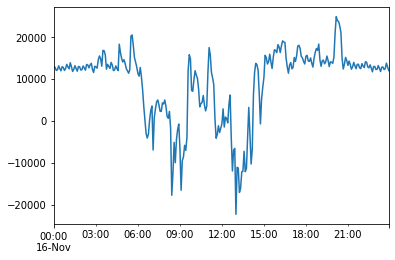

In [147]:
sbrc.loc[sim_date]['AvgP3'].resample('5min').mean().plot()

### Import IFH Data

In [97]:
ifh_1 = pd.read_csv('CSV/IFH SWBD - Hioki PW3198 30sec 20200803 to 20200824.CSV')
ifh_2 = pd.read_csv('CSV/IFH SWBD - Hioki PW3198 30sec 20200824 to 20200910.CSV')
ifh_3 = pd.read_csv('CSV/IFH SWBD - Hioki PW3198 30sec 20200910 to 20201015.CSV')
ifh_4 = pd.read_csv('CSV/IFH SWBD - Hioki PW3198 30sec 20201020 to 20201124.CSV')

In [98]:
ifh = pd.concat([ifh_1, ifh_2, ifh_3, ifh_4])

In [99]:
ifh.index = pd.to_datetime((ifh['Date']+' '+ifh['Time']), format='%Y/%m/%d %H:%M:%S')

<AxesSubplot:>

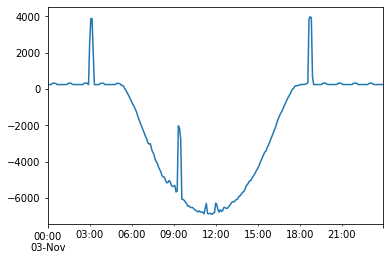

In [100]:
ifh.loc[sim_date]['AvgP3'].resample('5min').mean().plot()

### Import DRH Data

In [101]:
drh_1 = pd.read_csv('CSV/DRH - Hioki 3360 20200806 to 20200817.CSV', skiprows=16)
drh_1.index = pd.to_datetime((drh_1['Date']), format='%Y-%m-%d %H:%M:%S')

In [102]:
drh_2 = pd.read_csv('CSV/DRH SWBD - Hioki PW3360 30sec 20200817 to 20201020.CSV', skiprows=16)
drh_2.index = pd.to_datetime((drh_2['Date']), format='%Y-%m-%d %H:%M:%S')

In [103]:
drh_3 = pd.read_csv('CSV/DRH SWBD - Hioki PW3360 30sec 20202010 to 20201218.CSV', skiprows=16)
drh_3.index = pd.to_datetime((drh_3['Date']), format='%d/%m/%Y %H:%M')

In [104]:
drh = pd.concat([drh_1, drh_2, drh_3])

<AxesSubplot:xlabel='Date'>

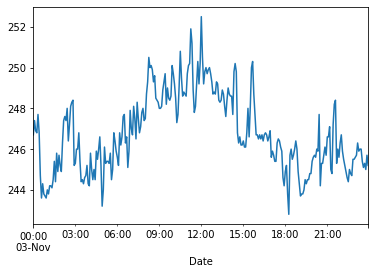

In [105]:
drh.loc[sim_date]['U1_Avg[V]'].resample('5min').mean().plot()
#drh.loc[sim_date]['P3_Avg[W]'].plot()

### Import Kiosk Data

In [106]:
kiosk_1 = pd.read_csv('CSV/Camp East Kiosk - Hioki PW3198 30sec 20200803 to 20200817 with n.CSV')
kiosk_2 = pd.read_csv('CSV/Camp East Kiosk - Hioki PW3198 30sec 20200817 to 20200921 with n.CSV')
kiosk_3 = pd.read_csv('CSV/Camp East Kiosk - Hioki PW3198 30sec 20201019 to 20201123 with n.CSV')

/home/brendan/jupyter_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [107]:
kiosk = pd.concat([kiosk_1, kiosk_2, kiosk_3])
kiosk.index = pd.to_datetime((kiosk['Date']+' '+kiosk['Time']), format='%Y/%m/%d %H:%M:%S')

### Import PV Data

## Create Combined DF

In [108]:
mg = pd.DataFrame(index=drh.index)

In [109]:
#Import Kiosk Voltage
mg['TX_Va'] = kiosk['AvgUrms1']
mg['TX_Vb'] = kiosk['AvgUrms2']
mg['TX_Vc'] = kiosk['AvgUrms3']

In [110]:
#Import SBRC Data
mg['SB_Va'] = sbrc['AvgUrms1']
mg['SB_Vb'] = sbrc['AvgUrms2']
mg['SB_Vc'] = sbrc['AvgUrms3']

mg['SB_Pa'] = sbrc['AvgP1']
mg['SB_Pb'] = sbrc['AvgP2']
mg['SB_Pc'] = sbrc['AvgP3']

mg['SB_Qa'] = sbrc['AvgQ1']
mg['SB_Qb'] = sbrc['AvgQ2']
mg['SB_Qc'] = sbrc['AvgQ3']

In [111]:
#Import IFH Data
mg['IF_Vc'] = ifh['AvgUrms3']
mg['IF_Pc'] = ifh['AvgP3']
mg['IF_Qc'] = ifh['AvgQ3']

In [112]:
#Import DRH Data
mg['DR_Va'] = drh['U1_Avg[V]']
mg['DR_Pa'] = drh['P1_Avg[W]']
mg['DR_Qa'] = drh['Q1_Avg[var]']

In [113]:
mg = mg.resample('5min').mean()

## Create Network Model

In [127]:
def time_series_powerflow(scale):
    
    sim_results = pd.DataFrame(index=mg.loc[sim_date].index, columns=['SB_Va', 'SB_Vb', 'SB_Vc', 'IF_Vc', 'DR_Va'])

    for i,idx in enumerate(sim_results.index):

        net = pp.create_empty_network(sn_mva=100)

        cable_25mm = dict(r_ohm_per_km=0.884,
                      x_ohm_per_km=0.0973,
                      c_nf_per_km=0.0,
                      r0_ohm_per_km=0.884,
                      x0_ohm_per_km=0.0973,
                      c0_nf_per_km=0.0,
                      max_i_ka=0.09,
                     )

        cable_95mm = dict(r_ohm_per_km=0.193,
                          x_ohm_per_km=0.09,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.772,
                          x0_ohm_per_km=0.36,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.244,
                         )

        cable_240mm = dict(r_ohm_per_km=0.0754/2,
                          x_ohm_per_km=0.0855/2,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.3016/2,
                          x0_ohm_per_km=0.342/2,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.426,
                         )

        pp.create_std_type(net, cable_25mm, '25mm')
        pp.create_std_type(net, cable_95mm, '95mm')
        pp.create_std_type(net, cable_240mm, '240mm')


        b1 = pp.create_bus(net, vn_kv=0.4, name='LV-TX', geodata=(-34.399961,150.898769))
        b2 = pp.create_bus(net, vn_kv=0.4, name='SBRC',geodata=(-34.400124,150.899592))
        b3 = pp.create_bus(net, vn_kv=0.4, name='PILLAR',geodata=(-34.401032,150.897985))
        b4 = pp.create_bus(net, vn_kv=0.4, name='IFH',geodata=(-34.400898,150.897876))
        b5 = pp.create_bus(net, vn_kv=0.4, name='DRH',geodata=(-34.400762,150.897466))

        pp.create_line(net, from_bus=b1, to_bus=b2, length_km=0.1, name="Line1",std_type='240mm') 
        pp.create_line(net, from_bus=b2, to_bus=b3, length_km=0.3, name="Line2",std_type='95mm') 
        pp.create_line(net, from_bus=b3, to_bus=b4, length_km=0.05, name="Line3",std_type='25mm') 
        pp.create_line(net, from_bus=b3, to_bus=b5, length_km=0.08, name="Line4",std_type='25mm')

        pp.create_ext_grid(net, vm_pu=mg.loc[idx]['SB_Va']/230, bus=b1, s_sc_max_mva=10000, rx_max=0.1)
        net.ext_grid["r0x0_max"] = 0.1
        net.ext_grid["x0x_max"] = 1.0


        pp.create_asymmetric_load(net, bus=b2, p_a_mw=(mg.loc[idx]['SB_Pa']/1000000), q_a_mvar=(mg.loc[idx]['SB_Qa']/1000000), 
                                               p_b_mw=(mg.loc[idx]['SB_Pb']/1000000), q_b_mvar=(mg.loc[idx]['SB_Qb']/1000000),
                                               p_c_mw=(mg.loc[idx]['SB_Pc']/1000000), q_c_mvar=(mg.loc[idx]['SB_Qc']/1000000), name="SBRC_Load")
        pp.create_asymmetric_load(net, bus=b4, p_c_mw=(mg.loc[idx]['IF_Pc']/1000000), q_c_mvar=(mg.loc[idx]['IF_Qc']/1000000), name='IFH_Load')
        pp.create_asymmetric_load(net, bus=b5, p_a_mw=(mg.loc[idx]['DR_Pa']/1000000)*scale, q_a_mvar=(mg.loc[idx]['DR_Qa']/1000000), name='DRH_Load')

        pp.add_zero_impedance_parameters(net)
        pp.runpp_3ph(net, numba=False)

        res = net.res_bus_3ph

        #print(res)

        sim_results.loc[idx,'SB_Va'] = res.loc[1]['vm_a_pu']*230
        sim_results.loc[idx,'SB_Vb'] = res.loc[1]['vm_b_pu']*230
        sim_results.loc[idx,'SB_Vc'] = res.loc[1]['vm_c_pu']*230
        sim_results.loc[idx,'DR_Va'] = res.loc[4]['vm_a_pu']*230
        sim_results.loc[idx,'IF_Vc'] = res.loc[3]['vm_c_pu']*230
        
    return sim_results
    

In [128]:
def plot_measured_actual(volts_df, bus_volts):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('kW')
    #ax1.set_ylim(-7,11)
    ax1.plot(volts_df.index, mg.loc[sim_date][bus_volts], linewidth=1, label='MEASURED')
#     ax1.plot(volts_df.index, mg.loc[sim_date]['TX_Va'], linewidth=1, label='MEASURED')
#     ax1.plot(volts_df.index, mg.loc[sim_date]['SB_Va'], linewidth=1, label='MEASURED')
    ax1.plot(volts_df.index, volts_df[bus_volts], color='blue', linewidth=1, label='GRID')
    ax1.legend(loc="upper left")
    ax1.grid()
    fig.set_figheight(6)
    fig.set_figwidth(9)
    plt.show()

In [129]:
volts_before = time_series_powerflow(scale=1)

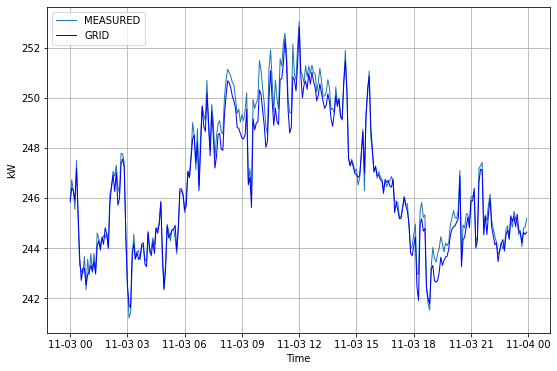

In [130]:
plot_measured_actual(volts_before,'IF_Vc')

In [43]:
#volts_after = time_series_powerflow(scale=1.02)

In [44]:
delta_v = volts_before - volts_after

In [45]:
delta_p_dr = mg.loc[sim_date]['DR_Pa'] - (mg.loc[sim_date]['DR_Pa']*1.02)

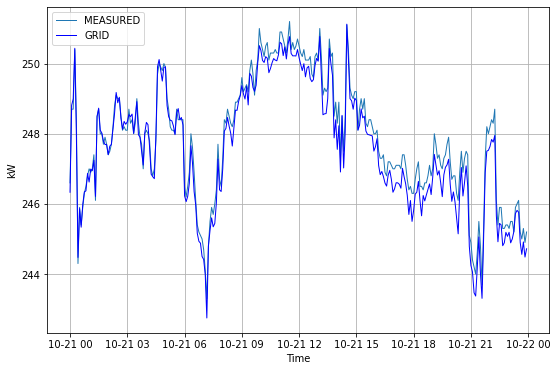

In [49]:
plot_measured_actual(volts_before, bus_volts='DR_Va')

# Calculate Sensitivities with Fixed Network state

The following function determines the network state with only 

In [95]:
def sensitivity_calc(scale):
    
    dr_fake_load = np.linspace(-20000,20000, num=288)
    
    sim_results = pd.DataFrame(index=mg.loc[sim_date].index, columns=['SB_Va', 'SB_Vb', 'SB_Vc', 'IF_Vc', 'DR_Va'])

    for i,idx in enumerate(sim_results.index):

        net = pp.create_empty_network(sn_mva=100)

        cable_25mm = dict(r_ohm_per_km=0.884,
                      x_ohm_per_km=0.0973,
                      c_nf_per_km=0.0,
                      r0_ohm_per_km=0.884,
                      x0_ohm_per_km=0.0973,
                      c0_nf_per_km=0.0,
                      max_i_ka=0.09,
                     )

        cable_95mm = dict(r_ohm_per_km=0.193,
                          x_ohm_per_km=0.09,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.772,
                          x0_ohm_per_km=0.36,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.244,
                         )

        cable_240mm = dict(r_ohm_per_km=0.0754/2,
                          x_ohm_per_km=0.0855/2,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.3016/2,
                          x0_ohm_per_km=0.342/2,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.426,
                         )

        pp.create_std_type(net, cable_25mm, '25mm')
        pp.create_std_type(net, cable_95mm, '95mm')
        pp.create_std_type(net, cable_240mm, '240mm')


        b1 = pp.create_bus(net, vn_kv=0.4, name='LV-TX', geodata=(-34.399961,150.898769))
        b2 = pp.create_bus(net, vn_kv=0.4, name='SBRC',geodata=(-34.400124,150.899592))
        b3 = pp.create_bus(net, vn_kv=0.4, name='PILLAR',geodata=(-34.401032,150.897985))
        b4 = pp.create_bus(net, vn_kv=0.4, name='IFH',geodata=(-34.400898,150.897876))
        b5 = pp.create_bus(net, vn_kv=0.4, name='DRH',geodata=(-34.400762,150.897466))

        pp.create_line(net, from_bus=b1, to_bus=b2, length_km=0.1, name="Line1",std_type='240mm') 
        pp.create_line(net, from_bus=b2, to_bus=b3, length_km=0.3, name="Line2",std_type='95mm') 
        pp.create_line(net, from_bus=b3, to_bus=b4, length_km=0.05, name="Line3",std_type='25mm') 
        pp.create_line(net, from_bus=b3, to_bus=b5, length_km=0.08, name="Line4",std_type='25mm')

        pp.create_ext_grid(net, vm_pu=1.08, bus=b1, s_sc_max_mva=10000, rx_max=0.1)
        net.ext_grid["r0x0_max"] = 0.1
        net.ext_grid["x0x_max"] = 1.0


        pp.create_asymmetric_load(net, bus=b2, p_a_mw=(10000/1000000), q_a_mvar=(0/1000000), 
                                               p_b_mw=(10000/1000000), q_b_mvar=(0/1000000),
                                               p_c_mw=(dr_fake_load[i]/1000000)*scale, q_c_mvar=(0/1000000), name="SBRC_Load")
        pp.create_asymmetric_load(net, bus=b4, p_c_mw=(1000/1000000), q_c_mvar=(0/1000000), name='IFH_Load')
        pp.create_asymmetric_load(net, bus=b5, p_a_mw=(1000/1000000), q_a_mvar=(0/1000000), name='DRH_Load')

        pp.add_zero_impedance_parameters(net)
        pp.runpp_3ph(net, numba=False)

        res = net.res_bus_3ph

        #print(res)

        sim_results.loc[idx,'SB_Va'] = res.loc[1]['vm_a_pu']*230
        sim_results.loc[idx,'SB_Vb'] = res.loc[1]['vm_b_pu']*230
        sim_results.loc[idx,'SB_Vc'] = res.loc[1]['vm_c_pu']*230
        sim_results.loc[idx,'DR_Va'] = res.loc[4]['vm_a_pu']*230
        sim_results.loc[idx,'IF_Vc'] = res.loc[3]['vm_c_pu']*230
        
    return sim_results
    

In [96]:
before = sensitivity_calc(scale=1)

In [97]:
after = sensitivity_calc(scale=1.02)

In [98]:
delta_v = before - after

In [99]:
delta_p = np.linspace(-20000,20000, num=288) - np.linspace(-20000,20000, num=288)*1.02

<AxesSubplot:xlabel='Date'>

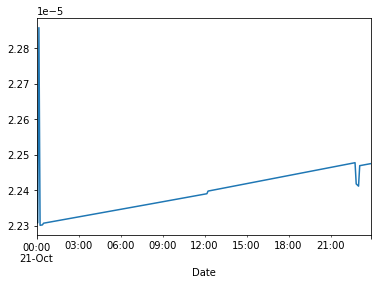

In [104]:
pd.Series(delta_v['DR_Va']/delta_p).plot()